# Stylometry: Einstein vs. Heisenberg examples

adapted from programming historian stylometry; unfortunately the PDF quality used here is low

In [1]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# general import
import os,re
import fnmatch

In [3]:
# specific imports
import nltk
import math

In [4]:
# module for PDF reading; requires JDK (java development toolkit)
from tika import parser

## Read PDF files and group by author

In [5]:
# define authors
all_authors = ("Einstein", "Heisenberg", "Disputed", "Testcase")

In [6]:
# path to author files
author_path = {}
author_path["Einstein"] = './Einstein'
author_path["Heisenberg"] = './Heisenberg'
author_path["Disputed"] = './Disputed'
author_path["Testcase"] = './Testcase'

In [7]:
# define search pattern to include files in list
pattern = '*.pdf'

In [8]:
# search pdfs in each path and make list
author_list = {}
for author in all_authors:
    author_list[author] = []
    for dirpath, dirnames, filenames in os.walk(author_path[author]):
        if not filenames:
            continue
        pdf_files = fnmatch.filter(filenames, pattern)
        if pdf_files:
            for file in pdf_files:
                author_list[author].append('{}/{}'.format(dirpath, file))
                print(author, ':\t\t{}/{}'.format(dirpath, file))

Einstein :		./Einstein/Einstein1916_Article_ElementareTheorieDerWasserwell.pdf
Einstein :		./Einstein/Einstein1918_Einwaende_gegen_die_Reltheorie.pdf
Heisenberg :		./Heisenberg/Heisenberg1926_Article_MehrkoerperproblemUndResonanzIn.pdf
Heisenberg :		./Heisenberg/Heisenberg1932_BauDerAtomkerne.pdf
Disputed :		./Disputed/Einstein-Ehrenfest1922_Article_QuantentheoretischeBemerkungen.pdf
Testcase :		./Testcase/Einstein1924_Gedenken_Kelvin.pdf


In [9]:
# parse pdf files
author_corpus = {}
for author in all_authors:
    author_corpus[author] = []
    for n in range (len(author_list[author])):
        l = author_list[author][n]
        print (str(n)+' : ',l)
        parsedPDF = parser.from_file(l)
        pdftext = parsedPDF['content']
        author_corpus[author].append(pdftext)

0 :  ./Einstein/Einstein1916_Article_ElementareTheorieDerWasserwell.pdf
1 :  ./Einstein/Einstein1918_Einwaende_gegen_die_Reltheorie.pdf
0 :  ./Heisenberg/Heisenberg1926_Article_MehrkoerperproblemUndResonanzIn.pdf
1 :  ./Heisenberg/Heisenberg1932_BauDerAtomkerne.pdf
0 :  ./Disputed/Einstein-Ehrenfest1922_Article_QuantentheoretischeBemerkungen.pdf
0 :  ./Testcase/Einstein1924_Gedenken_Kelvin.pdf


In [10]:
scientists_by_author = {}
for author in all_authors:
    scientists_by_author[author] = author_corpus[author][0]
    for n in range(1, len(author_list[author])):
        print (author, n)
        scientists_by_author[author] += author_corpus[author][n]

Einstein 1
Heisenberg 1


## Mendenhall’s Characteristic Curves of Composition

In [11]:
authors = all_authors

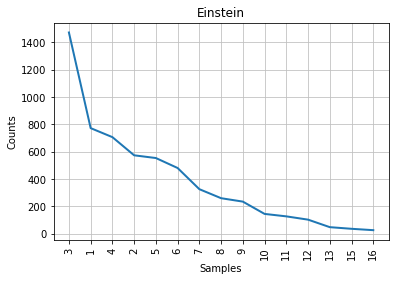

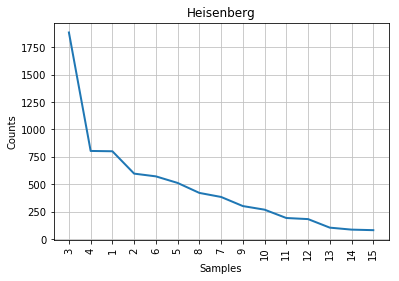

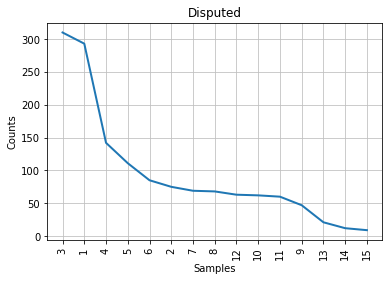

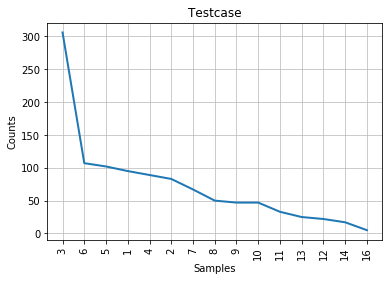

In [12]:
# Transform the authors' corpora into lists of word tokens
scientists_by_author_tokens = {}
scientists_by_author_length_distributions = {}
for author in authors:
    tokens = nltk.word_tokenize(scientists_by_author[author])
    
    # MODIFIED: Filter out punctuation
    scientists_by_author_tokens[author] = ([token for token in tokens if token.isalpha()])
   
    # Get a distribution of token lengths
    token_lengths = [len(token) for token in scientists_by_author_tokens[author]]
    scientists_by_author_length_distributions[author] = nltk.FreqDist(token_lengths)
    scientists_by_author_length_distributions[author].plot(15,title=author)      

## Kilgariff’s Chi-Squared Method

In [13]:
# Lowercase the tokens so that the same word, capitalized or not, 
# counts as one word
for author in authors:
    scientists_by_author_tokens[author] = (
        [token.lower() for token in scientists_by_author_tokens[author]])

In [14]:
# Calculate chisquared for each of the two candidate authors
for author in ["Einstein", "Heisenberg"]:
   
    # First, build a joint corpus and identify the 500 most frequent words in it
    joint_corpus = (scientists_by_author_tokens[author] + 
                    scientists_by_author_tokens["Disputed"])
    joint_freq_dist = nltk.FreqDist(joint_corpus)
    most_common = list(joint_freq_dist.most_common(500))

    # What proportion of the joint corpus is made up 
    # of the candidate author's tokens?
    author_share = (len(scientists_by_author_tokens[author]) 
                    / len(joint_corpus))
    
    # Now, let's look at the 500 most common words in the candidate 
    # author's corpus and compare the number of times they can be observed 
    # to what would be expected if the author's papers 
    # and the Disputed papers were both random samples from the same distribution.
    chisquared = 0
    for word,joint_count in most_common:
        
        # How often do we really see this common word?
        author_count = scientists_by_author_tokens[author].count(word)
        disputed_count = scientists_by_author_tokens["Disputed"].count(word)
        
        # How often should we see it?
        expected_author_count = joint_count * author_share
        expected_disputed_count = joint_count * (1-author_share)
        
        # Add the word's contribution to the chi-squared statistic
        chisquared += ((author_count-expected_author_count) * 
                       (author_count-expected_author_count) / 
                       expected_author_count)
                    
        chisquared += ((disputed_count-expected_disputed_count) *
                       (disputed_count-expected_disputed_count) 
                       / expected_disputed_count)
        
    print("The Chi-squared statistic for candidate", author, "is", chisquared)

The Chi-squared statistic for candidate Einstein is 1260.9058295450916
The Chi-squared statistic for candidate Heisenberg is 1355.2662821520755


## John Burrows’ Delta Method 

In [15]:
# Lowercase the tokens so that the same word, capitalized or not, counts as one word
for author in all_authors:
    scientists_by_author_tokens[author] = ([token.lower() for token in scientists_by_author_tokens[author]])

In [16]:
authors = ["Einstein", "Heisenberg", "Disputed"]

In [17]:
# Combine every paper except our test case into a single corpus
whole_corpus = []
for author in authors:
    whole_corpus += scientists_by_author_tokens[author]

In [18]:
# Get a frequency distribution
whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(30))
whole_corpus_freq_dist[ :10 ]

[('die', 585),
 ('der', 575),
 ('in', 272),
 ('n', 195),
 ('und', 191),
 ('e', 186),
 ('t', 184),
 ('den', 160),
 ('yon', 154),
 ('i', 154)]

In [19]:
# Initialize main data structure
features = [word for word,freq in whole_corpus_freq_dist]
feature_freqs = {}

In [20]:
# Calculate features for each author (subcorpus)
for author in authors:
    # A dictionary for each candidate's features
    feature_freqs[author] = {} 
    
    # A helper value containing the number of tokens in the author's subcorpus
    overall = len(scientists_by_author_tokens[author])
    
    # Calculate each feature's presence in the subcorpus
    for feature in features:
        presence = scientists_by_author_tokens[author].count(feature)
        feature_freqs[author][feature] = presence / overall

In [21]:
# Data structure for storing the "corpus standard" statistics
corpus_features = {}

In [22]:
# Calculate mean and standard deviation for each feature
for feature in features:
    # Create a sub-dictionary that will contain the feature's mean 
    # and standard deviation
    corpus_features[feature] = {}
    
    # Calculate the mean of the frequencies expressed in the subcorpora
    feature_average = 0
    for author in authors:
        feature_average += feature_freqs[author][feature]
    feature_average /= len(authors)
    corpus_features[feature]["Mean"] = feature_average
    
    # Calculate the standard deviation using the basic formula for a sample
    feature_stdev = 0
    for author in authors:
        diff = feature_freqs[author][feature] - corpus_features[feature]["Mean"]
        feature_stdev += diff*diff
    feature_stdev /= (len(authors) - 1)
    feature_stdev = math.sqrt(feature_stdev)
    corpus_features[feature]["StdDev"] = feature_stdev

#### Calculating z-scores

In [23]:
feature_zscores = {}
for author in authors:
    feature_zscores[author] = {}
    for feature in features:
        
        # Z-score definition = (value - mean) / stddev
        # We use intermediate variables to make the code easier to read
        feature_val = feature_freqs[author][feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        feature_zscores[author][feature] = ((feature_val-feature_mean) / feature_stdev)

In [24]:
# Tokenize the test case
testcase_tokens = nltk.word_tokenize(scientists_by_author["Testcase"])
    
# MODIFIED: Filter out punctuation and lowercase the tokens
testcase_tokens = [token.lower() for token in testcase_tokens if token.isalpha() ]
 
# Calculate the test case's features
overall = len(testcase_tokens)
testcase_freqs = {}
for feature in features:
    presence = testcase_tokens.count(feature)
    testcase_freqs[feature] = presence / overall
    
# Calculate the test case's feature z-scores
testcase_zscores = {}
for feature in features:
    feature_val = testcase_freqs[feature]
    feature_mean = corpus_features[feature]["Mean"]
    feature_stdev = corpus_features[feature]["StdDev"]
    testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    print("Test case z-score for feature", feature, "is", testcase_zscores[feature])

Test case z-score for feature die is 0.45849665395087713
Test case z-score for feature der is 2.644459410822605
Test case z-score for feature in is -0.023511608368336274
Test case z-score for feature n is -1.674717551262439
Test case z-score for feature und is 1.6518092152889596
Test case z-score for feature e is -1.2581086349645774
Test case z-score for feature t is -0.841406399051676
Test case z-score for feature den is -0.797463281853443
Test case z-score for feature yon is -0.5968744637597945
Test case z-score for feature i is -4.914437077621041
Test case z-score for feature des is 0.31559098956471726
Test case z-score for feature ist is 1.0564124687391883
Test case z-score for feature das is -0.9462159392363173
Test case z-score for feature r is -1.104306708378467
Test case z-score for feature zu is 0.3009040526888488
Test case z-score for feature eine is 0.3830892077256473
Test case z-score for feature a is 0.63885347313496
Test case z-score for feature l is -1.7315006542433935
T

#### Calculating delta

In [25]:
for author in authors:
    delta = 0
    for feature in features:
        delta += math.fabs((testcase_zscores[feature] - 
                            feature_zscores[author][feature]))
    delta /= len(features)
    print( "Delta score for candidate", author, "is", delta )

Delta score for candidate Einstein is 1.6305166399162199
Delta score for candidate Heisenberg is 1.451374738331085
Delta score for candidate Disputed is 1.9516831900939793
